# 02805 Social graphs and interactions - Project Assignment B
## A Temporal Network Analysis of Locations in the Harry Potter Book Series
##### Created by s181487 and s206759

This notebook will take you through the analysis of the Harry Potter location network. Here we show that the dominance of locations evolves throughout the series, and so does the sentiment. Early books feature happier locations, while later books emphasise sadder locations, resembling the overall darkening tendency of the books. This demonstrates that temporal network analysis of locations can provide insights into narrative structure and emotional development, offering a new approach beyond traditional character-focused studies.

### Table of content
1. Construnction of network
2. Network degree analysis
3. Temporal analysis of weighted degree nodes
4. Mean Chapter Index
5. Sentiment Analysis

In [37]:
# Load necessary libraries
import os
import re
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import requests
import statistics
import powerlaw
import numpy as np
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import requests
import mwparserfromhell
from tqdm import tqdm
from nltk import FreqDist
from nltk.corpus import stopwords
import pandas as pd
import requests
import csv
import io
import seaborn as sns

## 1. Construnction of network

In [38]:
# locations
locations = [
    "Privet Drive", "Godric’s Hollow", "Burrow", "Little Hangleton",
    "Malfoy Manor", "Grimmauld Place", "Spinner’s End", "Shell Cottage",
    "Beauxbatons", "Durmstrang", "Hogwarts", "The Leaky Cauldron", "Diagon Alley",
    "Flourish and Blotts", "Gringotts", "Ollivanders", "Weasleys’ Wizard Wheezes",
    "Knockturn Alley", "Platform Nine and Three-Quarters", "Hogsmeade",
    "Honeydukes", "Hog’s Head", "The Shrieking Shack", "The Three Broomsticks",
    "Azkaban", "Ministry of Magic", "Forbidden Forest", "Room of Requirement",
    "Dervish and Banges", "Madam Malkin’s Robes for All Occasions", "Madam Puddifoot’s",
    "Chamber of Secrets", "Room of Hidden Things", "the zoo", "Riddle House",
    "St. Mungo’s", "Owlery", "Quality Quidditch Supplies", "Auror Office",
    "Great Hall", "Entrance Hall", "Gryffindor Common Room", 
    "Boys’ Dormitory", "Divination Class", "Astronomy Tower", "Transfiguration department",
    "Charms Classroom", "Defense Against the Dark Arts Class", "Herbology Greenhouses",
    "Library", "Hospital Wing", "Prefects’ Bathroom", "Hagrid’s Hut",
    "Headmaster’s Office", "Kitchens", "Trophy Room", "Forbidden Corridor",
    "Hogwarts Express", "Quidditch Pitch", "Ravenclaw Common Room", "Slytherin Common Room",
    "Dungeons", "Lake", "Whomping Willow"
]


# same locations but matching Wikipedia article titles for convenience
places_wiki = [
    "4 Privet Drive", "Godric's Hollow", "The Burrow", "Little Hangleton",
    "Malfoy Manor", "Grimmauld Place", "Spinner's End", "Shell Cottage",
    "Beauxbatons", "Durmstrang", "Hogwarts", "The Leaky Cauldron", "Diagon Alley",
    "Flourish and Blotts", "Gringotts", "Ollivanders", "Weasleys' Wizard Wheezes",
    "Knockturn Alley", "Platform Nine and Three-Quarters", "Hogsmeade",
    "Honeydukes", "Hog's Head Inn", "The Shrieking Shack", "Three Broomsticks",
    "Azkaban", "Ministry of Magic", "Forbidden Forest", "Room of Requirement",
    "Dervish and Banges", "Madam Malkin's Robes for All Occasions", "Madam Puddifoot's",
    "Chamber of Secrets", "Room of Hidden Things", "Zoo", "The Riddle House",
    "St Mungo's Hospital for Magical Maladies and Injuries", "The Owlery", "Quality Quidditch Supplies", "British Auror Office",
    "Great Hall", "Entrance Hall", "Gryffindor Common Room", 
    "Gryffindor Boys' Dormitory", "Divination Classroom", "Astronomy Tower", "Transfiguration department",
    "Charms Classroom", "Defense Against the Dark Arts Classroom", "Hogwarts greenhouses",
    "Library", "Hospital Wing", "Prefects' Bathroom", "Hagrid's Hut",
    "Headmaster's Office", "Hogwarts Kitchens", "Trophy Room", "Forbidden Corridor",
    "Hogwarts Express", "Quidditch Pitch", "Ravenclaw Common Room", "Slytherin Common Room",
    "Dungeons", "Lake", "Whomping Willow"
]




The formatting of chapter beginnings was not uniform, some books included the word “Chapter,” while others simply provided the chapter title. To address this, we manually inserted --**-- at the start of every chapter so that the regular expressions could reliably detect chapter boundaries. we then use this as the regular expression to identify chapters correctly.

In [39]:
# Load books from GitHub
books = {}
github_base_url = "https://raw.githubusercontent.com/JBorregaardd/socialgraphs_assignment/main/"
api_url = "https://api.github.com/repos/JBorregaardd/socialgraphs/contents/books"

# List files
file_list = requests.get(api_url).json()

for item in file_list:
    if item["name"].endswith(".txt"):
        r = requests.get(item["download_url"])
        books[item["name"]] = r.text.lower()


# regular expression to find locations
place_patterns = {p: re.compile(rf"\b{re.escape(p.lower())}\b") for p in locations}

G = nx.Graph()
G.add_nodes_from(locations)

# regular expression to identify chapters
chapter_pattern = re.compile(r'--\*\*--')


chapters_by_place = {p: [] for p in locations}   
total_mentions    = {p: 0  for p in locations}   
global_chapter_idx = 0  


for book_name, text in books.items():
    chapters = [c for c in chapter_pattern.split(text) if c.strip()]
    print(f"Processing {book_name}: {len(chapters)} chapters found")

    for chapter_text in chapters:
        present = []

        # track global chapter index
        for p, pattern in place_patterns.items():
            matches = pattern.findall(chapter_text)
            if matches:
                present.append(p)
                chapters_by_place[p].append(global_chapter_idx)
                total_mentions[p] += len(matches)

        # add co-occurrence edges
        for a, b in itertools.combinations(present, 2):
            if G.has_edge(a, b):
                G[a][b]['weight'] += 1
            else:
                G.add_edge(a, b, weight=1)

        global_chapter_idx += 1

Processing 01 Harry Potter and the Sorcerers Stone.txt: 17 chapters found
Processing 02 Harry Potter and the Chamber of Secrets.txt: 18 chapters found
Processing 03 Harry Potter and the Prisoner of Azkaban.txt: 22 chapters found
Processing 04 Harry Potter and the Goblet of Fire.txt: 37 chapters found
Processing 05 Harry Potter and the Order of the Phoenix.txt: 38 chapters found
Processing 06 Harry Potter and the Half-Blood Prince.txt: 30 chapters found
Processing 07 Harry Potter and the Deathly Hallows.txt: 37 chapters found


### The Static Aggregated Network

The network studied in this report is a temporal Harry Potter locations network.  We employ all seven Harry Potter books as data. A total of $64$ locations were selected as nodes, and an edge was created between two locations if they were mentioned in the same chapter. The static aggregated network is defined as a union over all timestamps,
$$
\begin{equation*}
    G = \bigcup_{t=1}^7 G_t,
\end{equation*}
$$
where each $G_t$ represents the graph corresponding to one of the seven books and serves as a timestamp, so that $t=1,2,...,7$.


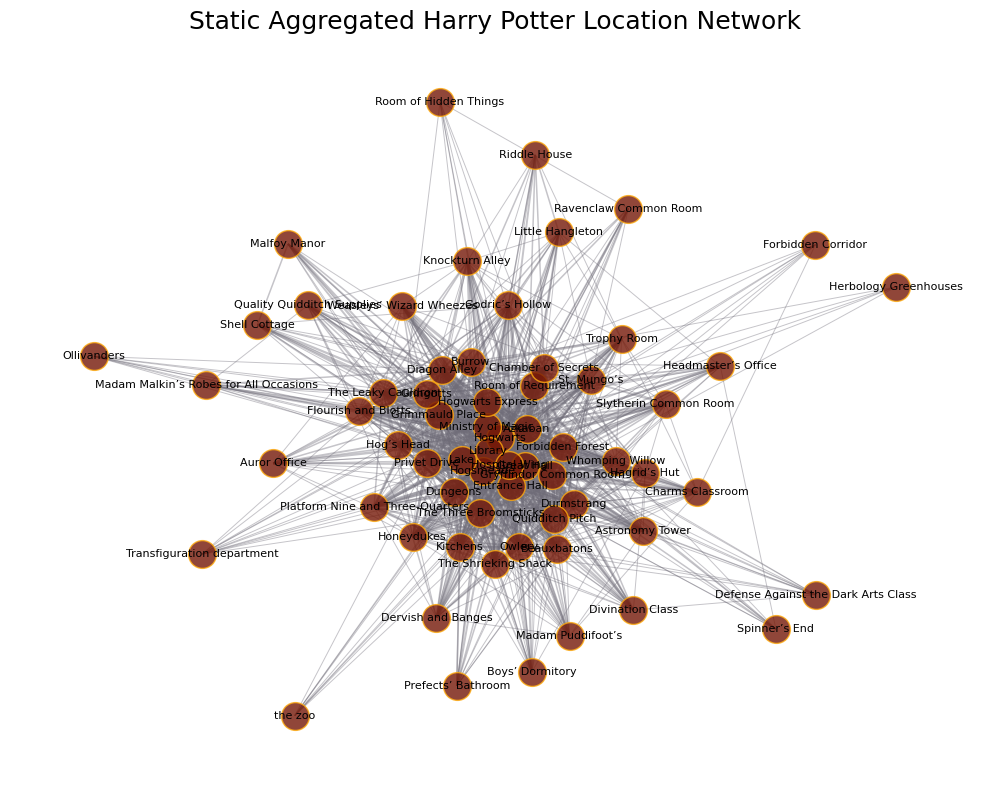

In [40]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.35)

nx.draw_networkx_nodes(
    G, pos,
    node_color="#751807",
    edgecolors="#FFAB0D",
    node_size=400,
    alpha=0.8
)

nx.draw_networkx_labels(
    G, pos,
    font_size=8
)

edges = list(G.edges(data=True))
weights = [d["weight"] for (_, _, d) in edges]
scaled_widths = [np.log1p(w) for w in weights]

nx.draw_networkx_edges(
    G, pos,
    edgelist=[(u, v) for u, v, _ in edges],
    width=scaled_widths,
    alpha=0.4,
    edge_color="#6F6C78"
)
plt.title("Static Aggregated Harry Potter Location Network", fontsize=18)
plt.axis("off")
plt.tight_layout()
plt.show()

The static aggregated network $G$ consist of a total of 879 edges across 199 total chapters in the book series, which corresponds to an average of $\frac{879}{199} \approx 4.4$ co-mentioned locations per chapter. The temporal network is an undirected weighted graph, where the weight of an edge reflects how many times the two locations were mentioned together.

## 2. Network degree analysis
From the following code we see that Hogwarts and the Ministry of Magic are the most frequently co-mentioned locations in the static aggregated network, and Hogwarts is the most central node, while the Herbology Greenhouses is the least.

In [41]:
# most and less connected locations
degrees = dict(G.degree(weight='weight'))
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
print("Most connected locations:")
for loc, deg in sorted_degrees[:3]:
    print(f"{loc}: {deg} connections")
print("Least connected locations:")
for loc, deg in sorted_degrees[-3:]:
    print(f"{loc}: {deg} connections")

# most weighted edges
sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
print("Most weighted edges:")
for u, v, data in sorted_edges[:3]:
    print(f"{u} - {v}: weight {data['weight']}")

Most connected locations:
Hogwarts: 1055 connections
Great Hall: 604 connections
Ministry of Magic: 554 connections
Least connected locations:
Room of Hidden Things: 8 connections
Forbidden Corridor: 8 connections
Herbology Greenhouses: 5 connections
Most weighted edges:
Hogwarts - Ministry of Magic: weight 76
Hogwarts - Great Hall: weight 72
Hogwarts - Azkaban: weight 60


In [42]:
# mean and median for degrees
degree_values = list(degrees.values())
mean_degree = statistics.mean(degree_values)
median_degree = statistics.median(degree_values)
print(f"Mean degree: {mean_degree:.2f}")
print(f"Median degree: {median_degree}")

# Assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity of chapter-based graph: {assortativity:.2f}")

# Power-law fitting
degrees = [d for n, d in G.degree(weight='weight')]
fit_power = powerlaw.Fit(degrees).alpha
print(f"Power-law exponent for chapter-based graph: {fit_power:.2f}")

Mean degree: 152.59
Median degree: 82.5
Degree assortativity of chapter-based graph: -0.29
Power-law exponent for chapter-based graph: 4.35


Calculating best minimal value for power law fit
/Users/signeolsen/opt/anaconda3/envs/MachineLearning/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


The static aggregated weighted network has a mean degree of $\langle k \rangle = 152.59$ and a median of $82.5$, with degrees ranging from $5$ to $1021$. This indicates a right-skewed degree distribution where a few nodes have exceptionally many connections, while most have substantially fewer. Although the degree distribution is strongly skewed, statistical tests indicate that it does not follow a power law. Instead, the tail decays more rapidly ($\alpha=4.35$), consistent with a heavy-tailed but not scale-free distribution. The above statistics shows that the strongest edge connections are between the most central nodes, indicating a dense core in the middle of the network. The network’s assortativity of $-0.29$ supports this, high-degree nodes tend to link to low-degree ones, indicating some hub-like behaviour.

A plot of the degree distribution alongside those of a scale-free and a random network to check for alignment with either distribution. As stated above, the degree distribution did not foloow any of those distrbutions. Consequently, this plot was not included in the report.

Power-law alpha: 4.3541376737569
Power-law xmin: 383.0


Calculating best minimal value for power law fit


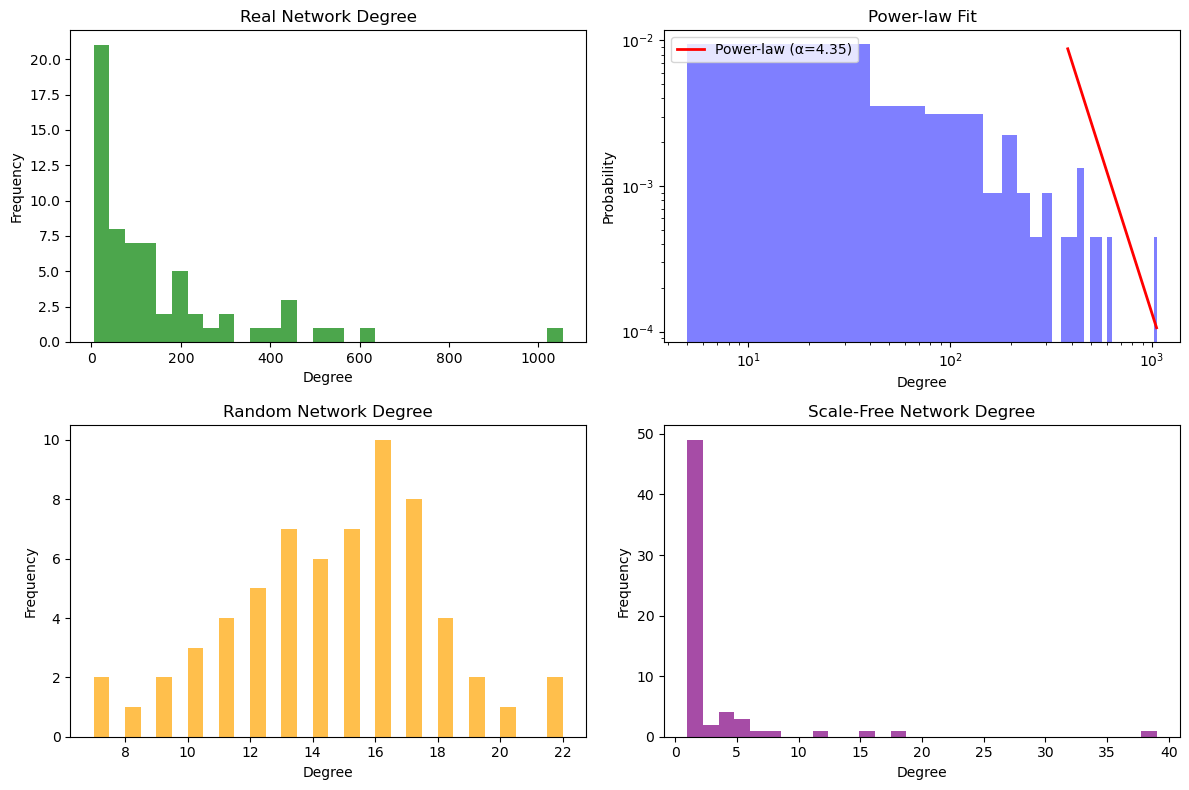

In [43]:
# Create reference networks
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# 1. Random network with same nodes and edges
p = num_edges / (num_nodes * (num_nodes - 1))
G_random = nx.gnp_random_graph(num_nodes, p, directed=False)
random_deg = dict(G_random.degree())

# 2. Scale-free network
G_scale_free = nx.scale_free_graph(num_nodes)
G_scale_free = nx.DiGraph(G_scale_free) 
scale_deg = dict(G_scale_free.degree())

# Real network degrees
degrees = dict(G.degree(weight='weight'))
degree_values = np.array(list(degrees.values()))

# 3. Power-law fits
fit_power = powerlaw.Fit(degree_values)
alpha = fit_power.alpha
xmin = fit_power.xmin

print("Power-law alpha:", alpha)
print("Power-law xmin:", xmin)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Top-left: degree histogram of real network
axes[0, 0].hist(degree_values, bins=30, color='green', alpha=0.7)
axes[0, 0].set_xlabel("Degree")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Real Network Degree")


# Top-right: Power-law fit
axes[0, 1].hist(degree_values, bins=30, density=True, alpha=0.5, color="blue")

fit_power.power_law.plot_pdf(ax=axes[0, 1], color='red', linewidth=2, label=f"Power-law (α={alpha:.2f})")

axes[0, 1].set_xlabel("Degree")
axes[0, 1].set_ylabel("Probability")
axes[0, 1].set_title("Power-law Fit")
axes[0, 1].legend()

# Bottom-left: Random network
axes[1, 0].hist(random_deg.values(), bins=30, color='orange', alpha=0.7)
axes[1, 0].set_xlabel("Degree")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Random Network Degree")

# Bottom-right: Scale-free network
axes[1, 1].hist(scale_deg.values(), bins=30, color='purple', alpha=0.7)
axes[1, 1].set_xlabel("Degree")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Scale-Free Network Degree")

plt.tight_layout()
plt.show()

## 3. Temporal analysis of weighted degree nodes

In [44]:
# one graph per book
graphs = {}

for i, (book_name, text) in enumerate(books.items(), 1):
    G = nx.Graph()
    G.add_nodes_from(locations)

    chapters = chapter_pattern.split(text)
    
    for chapter_text in chapters:
        present = [p for p, pattern in place_patterns.items() if pattern.search(chapter_text)]
        for a, b in itertools.combinations(present, 2):
            if G.has_edge(a, b):
                G[a][b]['weight'] += 1
            else:
                G.add_edge(a, b, weight=1)

    
    globals()[f"graph_{i}"] = G
    graphs[f"graph_{i}"] = G  

In [45]:
# Summary stats for each graph
for name, G in graphs.items():
    node_degrees = sorted(G.degree(weight='weight'), key=lambda x: x[1], reverse=True)
    top_nodes = node_degrees[:4]
    print(f"Top 3 most connected nodes in {name}:")
    for n, w in top_nodes:
        print(f"  {n:<25} {w}")

Top 3 most connected nodes in graph_1:
  Hogwarts                  78
  Gringotts                 65
  Library                   46
  Lake                      44
Top 3 most connected nodes in graph_2:
  Hogwarts                  95
  Hospital Wing             77
  Great Hall                74
  Chamber of Secrets        72
Top 3 most connected nodes in graph_3:
  Hogwarts                  146
  Hogsmeade                 132
  Ministry of Magic         96
  Great Hall                88
Top 3 most connected nodes in graph_4:
  Hogwarts                  199
  Durmstrang                136
  Great Hall                136
  Lake                      127
Top 3 most connected nodes in graph_5:
  Hogwarts                  226
  Ministry of Magic         176
  Great Hall                141
  Entrance Hall             132
Top 3 most connected nodes in graph_6:
  Hogwarts                  166
  Entrance Hall             84
  Ministry of Magic         80
  Hogsmeade                 74
Top 3 most 

Using weighted degree as a measure of significance, the above lists the 3 strongest nodes in each network. Hogwarts consistently appears as the highest-weighted node. But the most central location (after Hogwarts) is never the same across books, indicating a shift in which places play an important role in the narrative. This demonstrates that locations play a meaningful role in the storyline and development of the story. Furthermore, the changing significance of locations across the seven graphs indicates a clear temporal evolution in the network.

## 4. Mean Chapter Index

To visualize how all locations change in occurrence over
time, we plot each location according to its total number of
mentions and its mean chapter index. This makes the time domain explicit, as locations that
appear early, late, or consistently across the series separate
naturally in the plot.

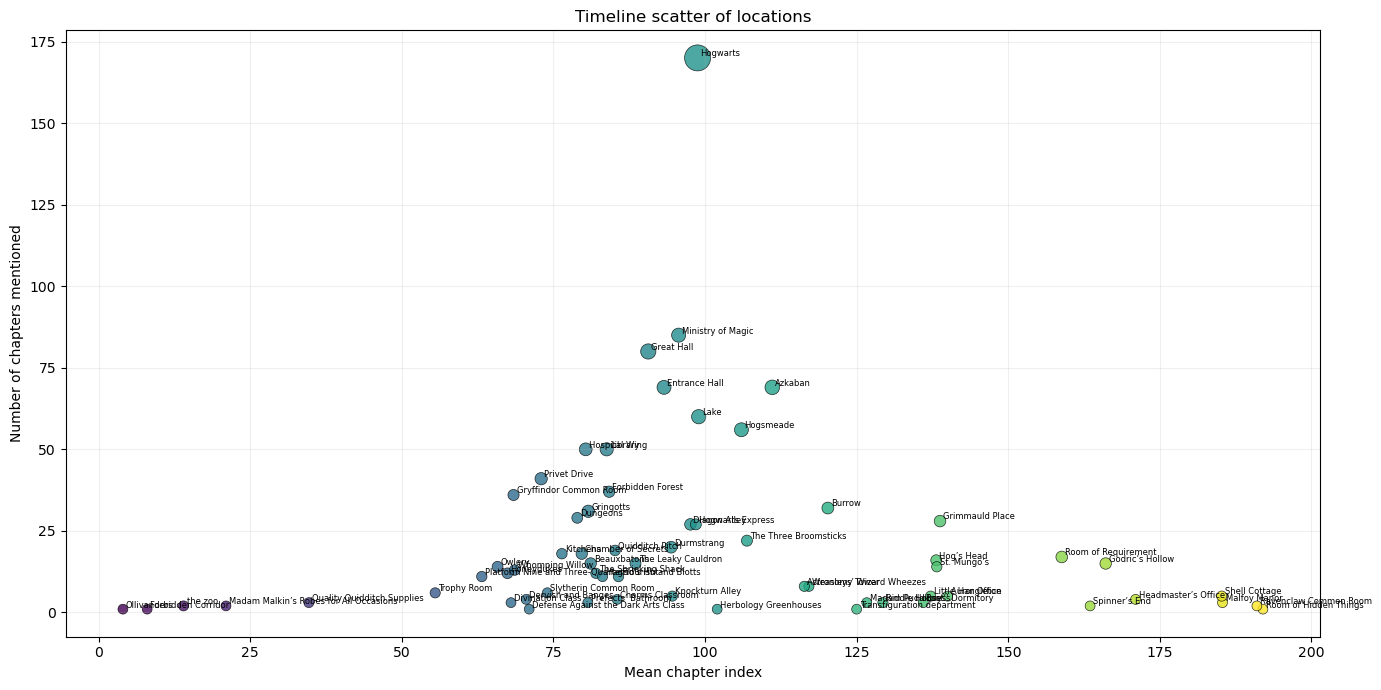

In [46]:
activity_span = {p: len(chapters_by_place[p]) for p in locations}
mean_chapter  = {p: np.mean(chapters_by_place[p]) for p in locations}

x = np.array([mean_chapter[p] for p in locations])
y = np.array([activity_span[p] for p in locations])
sizes = np.array([total_mentions[p] for p in locations])

sizes_scaled = 50 + 300 * (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-9)
x_norm = (x - x.min()) / (x.max() - x.min() + 1e-9)
colors = cm.viridis(x_norm)

fig, ax = plt.subplots(figsize=(14, 7))
sc = ax.scatter(x, y, s=sizes_scaled, c=colors, alpha=0.8,
                edgecolor="black", linewidth=0.5)

for p in locations:
    ax.text(
        mean_chapter[p] + 0.5,
        activity_span[p] + 0.5,
        p,
        fontsize=6
    )

ax.set_xlabel("Mean chapter index")
ax.set_ylabel("Number of chapters mentioned")
ax.set_title("Timeline scatter of locations")
ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()


Hogwarts stands out as an outlier,
being the most central location by far, appearing in 176
chapters with a mean chapter index of 98.76 around halfway
through the books. A lot of locations are grouped around the
middle of the graph, meaning they are fairly well mentioned
throughout the books. However, some of them appear mostly
early in the book series, like Platform nine and three Quarters,
while others occur mainly in the later books, such as Godric’s
Hollow. At the lower left, a cluster of low-frequency locations
appears early in the series, representing places that are
mentioned briefly and do not reappear later. These locations
include different shops from Diagon Alley, such as Ollivanders
and Quality Quidditch Supplies, alongside other specific
locations from the first two books. Opposite in the graph are
there several low-frequency but late-appearing locations on
the far right, marking settings that only become relevant in
the final books, such as Malfoy Manor and Room of Hidden
Things.

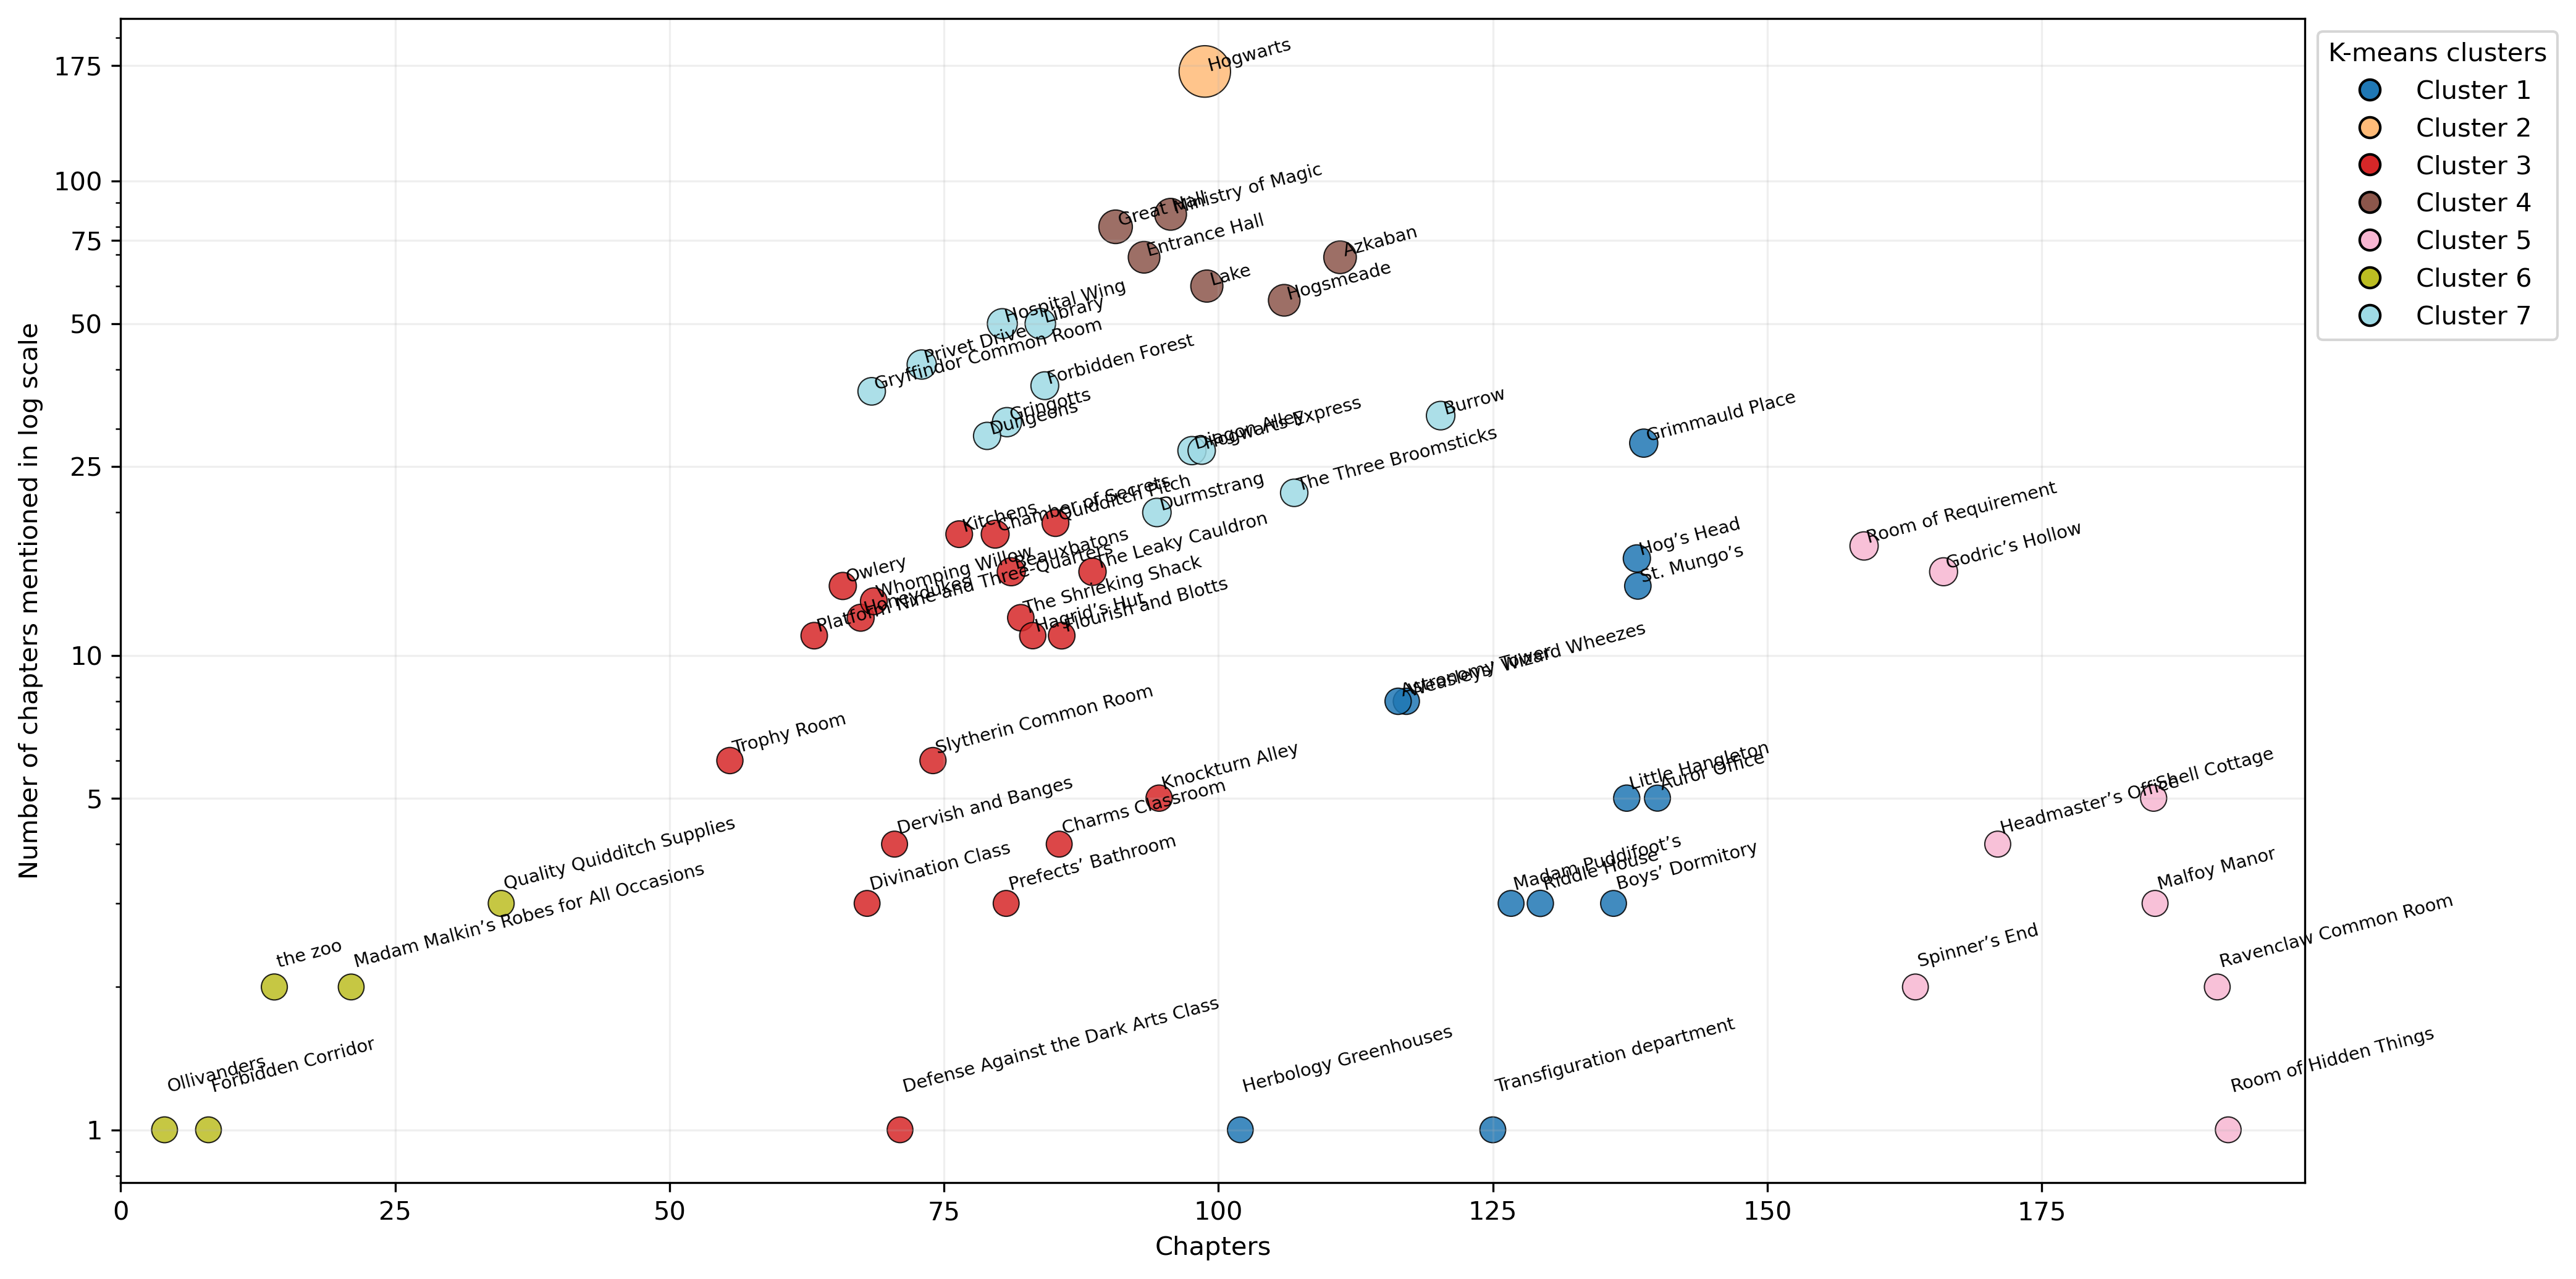

In [47]:
X = np.column_stack([x, y, sizes])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_clusters = 7
kmeans = KMeans(n_clusters=k_clusters, random_state=0)
cluster_ids = kmeans.fit_predict(X_scaled)

for place, cid in zip(locations, cluster_ids):
    if place in G:
        G.nodes[place]["cluster"] = int(cid)

sizes_scaled = 100 + 300 * (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-9)

fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

cmap = plt.get_cmap("tab20", k_clusters)
colors = cmap(cluster_ids)

sc = ax.scatter(
    x, y,
    s=sizes_scaled,
    c=colors,
    alpha=0.85,
    edgecolor="black",
    linewidth=0.5
)

for p, xv, yv in zip(locations, x, y):
    ax.text(
        xv + 0.4,
        yv + 0.2,
        p,
        fontsize=7,
        rotation=15,
        rotation_mode="anchor",
    )

ax.set_xlabel("Chapters")
ax.set_ylabel("Number of chapters mentioned in log scale")


handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               markerfacecolor=cmap(cid), markeredgecolor="black")
    for cid in range(k_clusters)
]
ax.legend(handles, [f"Cluster {cid+1}" for cid in range(k_clusters)],
          title="K-means clusters", bbox_to_anchor=(1, 1), loc="upper left")

ax.grid(alpha=0.2)

# transform y-axis to log scale and add indices
ax.set_yscale("log")
ax.set_yticks([1, 5, 10, 25, 50, 75, 
               100, 175])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim(0, x.max() + 7)

plt.tight_layout()
plt.show()


The locations are clustered into seven
groups using K-means clustering. The resulting clusters
exhibit clear temporal structure, separating early, mid-series,
and late-appearing locations based on their frequency and
narrative position. This organization highlights how the
setting of the story evolves over time and provides a structured
foundation for the subsequent sentiment analysis.

## 5. Sentiment Analysis

In the following part of the analysis
we conduct a sentiment analysis of both distinct locations and
the cluster partitions of the network that was found above

In [48]:
# Create a DataFrame for easier coding
df = pd.DataFrame({
    "location": locations,
    "cluster": cluster_ids,
    "mean_chapter": [mean_chapter[p] for p in locations]
})

As part of our sentiment analysis we used the Harry Potter
Fandom Wikipage for each location. The wikipages were
downloaded through the Fandom MediaWiki API, converted
to plain text by removing templates, links, image captions,
thumbnail formatting and other formatting elements using the
mwparserfromhell python package and regular expressions.
After cleaning, the resulting text was tokenized and processed
with NLTK to compute sentiment scores.

In [49]:
OUTPUT_FOLDER = "hp_wiki_txt"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

BASE_URL = "https://harrypotter.fandom.com/api.php"

# function to fetch wikitext of a page
def fetch_wikitext(page_title):
    params = {
        "action": "parse",
        "page": page_title,
        "prop": "wikitext",
        "format": "json",
        "redirects": 1
    }
    r = requests.get(BASE_URL, params=params)
    data = r.json()
    if "parse" in data and "wikitext" in data["parse"]:
        return data["parse"]["wikitext"]["*"]
    else:
        print(f" Could not fetch wikipage for: {page_title}")
        return ""
    
# function to convert wikitext to plain text
def wikitext_to_plaintext(wikitext):
    
    wikicode = mwparserfromhell.parse(wikitext)
    return wikicode.strip_code() 

# Loop over all locations
for place in tqdm(places_wiki, desc="Fetching pages"):
    safe_name = place.replace(" ", "_")  
    txt_path = os.path.join(OUTPUT_FOLDER, f"{safe_name}.txt")
    
    
    wikitext = fetch_wikitext(place)
    
    plain_text = wikitext_to_plaintext(wikitext)
    

    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(plain_text)


Fetching pages: 100%|██████████| 64/64 [00:17<00:00,  3.63it/s]


In [50]:
TXT_FOLDER = "hp_wiki_txt"

for fname in os.listdir(TXT_FOLDER):
    if not fname.endswith(".txt"):
        continue

    path = os.path.join(TXT_FOLDER, fname)
    with open(path, encoding="utf-8") as f:
        text = f.read()

    # end articles before "Appearances" section
    m = re.search(r"^\s*Appearances\s*$", text, flags=re.IGNORECASE | re.MULTILINE)
    if m:
        text = text[:m.start()]

    # remove junk fom text files
    text = re.sub(r"\b\d+\s*px\|thumb\|[^\n]*", "", text)
    text = re.sub(r"[ \t]{2,}", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)

    with open(path, "w", encoding="utf-8") as f:
        f.write(text.strip())

 To calculate the sentiment score, we used the LabMT wordlist. In addition,
we supplemented it with 50 Harry Potter–specific terms
such as patronus, crucio, horcrux, and quidditch. Since
these terms are not represented in LabMT but clearly carry
sentiment within the context of the Harry Potter universe,
we assigned them average happiness scores based on ratings
from the group members

In [51]:
# load in the LabMT sentiment lexicon
labmt = pd.read_csv(
    github_base_url + "pone.0026752.s001.txt",
    sep="\t",
    comment="#",
    skiprows=range(0, 3),
    header=0,
)
happiness_map = dict(zip(labmt["word"].str.lower(), labmt["happiness_average"]))

In [52]:
def load_manual_map(filename):
    text = requests.get(github_base_url + filename).text
    reader = csv.reader(io.StringIO(text))
    return {word: float(score) for word, score in reader}


manual_map = load_manual_map("hpord.txt")
manual_map_2 = load_manual_map("hpordsigne.txt")

averaged_map = {}
all_words = set(manual_map.keys()) | set(manual_map_2.keys())

for w in all_words:
    s1 = manual_map.get(w)
    s2 = manual_map_2.get(w)
    if s1 is not None and s2 is not None:
        averaged_map[w] = (s1 + s2) / 2
    elif s1 is not None:
        averaged_map[w] = s1
    else:
        averaged_map[w] = s2

happiness_map.update(averaged_map)

In [53]:
stop_words = set(stopwords.words("english"))

# sentiment score function
def sentiment(tokens, happiness_map=happiness_map, stop_words=stop_words):
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stop_words]

    sent_text = [token for token in tokens if token in happiness_map]

    fdist = FreqDist(sent_text)
    total_count = sum(fdist.values())
    total_happiness = sum(fdist[w] * happiness_map[w] for w in fdist)
    return total_happiness / total_count

In [54]:
#mapping from wiki titles to the names used to find locations in the book texts
wiki_to_node = dict(zip(places_wiki, locations))


cluster_attr = nx.get_node_attributes(G, "cluster")
n_clusters = max(cluster_attr.values()) + 1
cluster_texts = [""] * n_clusters     
cluster_members = [[] for _ in range(n_clusters)]  

# Read wiki texts and combine by cluster
missing_files = []
missing_clusters = []

for place, wiki_title in zip(locations, places_wiki):
    
    cid = cluster_attr.get(place)

    safe_name = wiki_title.replace(" ", "_")  
    path = os.path.join(TXT_FOLDER, f"{safe_name}.txt")

    with open(path, encoding="utf-8") as f:
        text = f.read()

    cluster_texts[cid] += " " + text
    cluster_members[cid].append(place)


In [55]:
def tokenize(text: str):
    return re.findall(r"\w+", text.lower())

cluster_sentiments = []

for cid in range(n_clusters):
    text = cluster_texts[cid]
    tokens = tokenize(text)
    s = sentiment(tokens)
    cluster_sentiments.append(s)
   
sent = np.array(cluster_sentiments)
z = (sent - sent.mean()) / sent.std()

for cid, score in enumerate(z):
    print(f"Cluster {cid+1}: z-normalized sentiment {score:.3f}") 

Cluster 1: z-normalized sentiment -0.784
Cluster 2: z-normalized sentiment 0.964
Cluster 3: z-normalized sentiment 0.541
Cluster 4: z-normalized sentiment -1.749
Cluster 5: z-normalized sentiment -0.664
Cluster 6: z-normalized sentiment 1.188
Cluster 7: z-normalized sentiment 0.504


For each of the seven clusters an average standardized sentiment score has been computed and presented.
The sentiment scores of the clusters suggest a pattern between when locations appear in the series and their emotional tone. Clusters with locations that appear later in the books as $C_1,C_2$ and $C_6$ have a below-average sentiment scores of $\{-0.425,-1.9,-0.624\}$ respectively. In the opposite end, clusters dominated by early-appearing locations tend to have above-average sentiment such as $C_4$ and $C_7$ that have above average sentiment scores. The main exception is $C_7$, which has a low mean chapter index and a  close to average sentiment score. Cluster $C_7$ includes some of the most frequently mentioned locations, meaning their wiki pages are well documented across the many times they appear, which may not always be in the same tone. However, the overall trend indicates that places that are more common later in the books tend to be described with more negative words than the ones that appeared earlier. This suggests that the locations function as narrative elements that contribute to the storytelling and tonal progression of the books.

## Sentiment score of individual places

We are also interested in investigating the sentiment scores of the wikipages of the individual locations. We will mainly focus on some of the more significant places throughout the series as defined by their weighted degree.

In [56]:
location_sentiment = {}

for place, wiki_title in zip(locations, places_wiki):
    safe_name = wiki_title.replace(" ", "_")
    txt_path = os.path.join(TXT_FOLDER, f"{safe_name}.txt")

    with open(txt_path, encoding="utf-8") as f:
        text = f.read()

    tokens = tokenize(text)
    score = sentiment(tokens)
    location_sentiment[place] = score

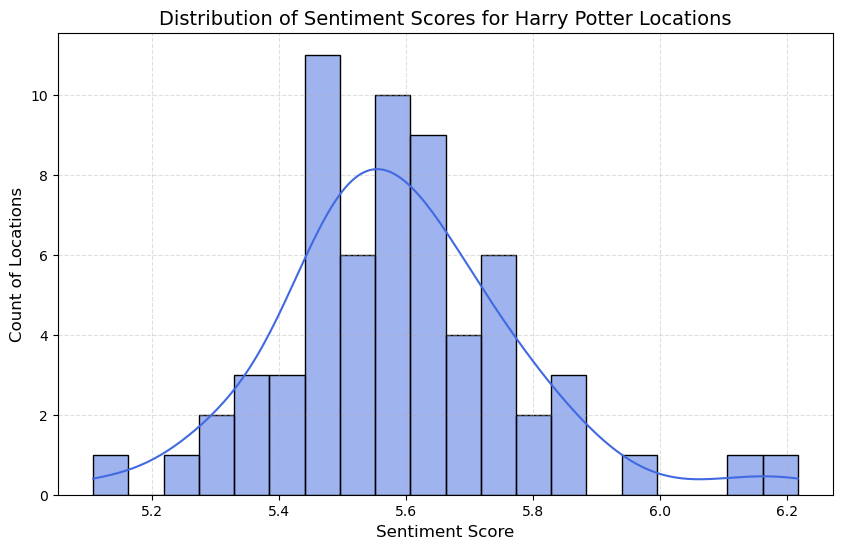

In [57]:

sorted_locations = sorted(
    location_sentiment.items(),
    key=lambda x: x[1] if x[1] is not None else float("nan"),
    reverse=True
)

scores = [s for _, s in sorted_locations if s is not None]

plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=20, kde=True,
             color="royalblue", edgecolor="black")

plt.title("Distribution of Sentiment Scores for Harry Potter Locations", fontsize=14)
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Count of Locations", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)

plt.show()

The above plot is not a part of our article but simply illustrates the sentiment scores of all the destinct locations as a barplot. We can see that the sentiment scores sort of follows a bell curve and that most places have a sentiment score of approximately 5.6

In [58]:
central_places = ['Hogwarts', 'Chamber of Secrets', 'Gringotts', 'Great Hall', 'Hospital Wing', 'Lake', 'Grimmauld Place',
                'Azkaban', 'Hogsmeade', 'Durmstrang', 'Ministry of Magic', 'Entrance Hall']

central_places_scores = {place: location_sentiment[place] for place in central_places if place in location_sentiment}

# the 4 happiste and saddiest places
sorted_places = sorted(central_places_scores.items(), key=lambda x: x[1])
saddiest = sorted_places[:5]
happiest = sorted_places[-5:]
print("\n--- Saddiest Central Places ---")
for place, score in saddiest:
    print(f"{place}: {score:.2f}")
print("\n--- Happiest Central Places ---")
for place, score in happiest:
    print(f"{place}: {score:.2f}")


--- Saddiest Central Places ---
Azkaban: 5.11
Hospital Wing: 5.23
Chamber of Secrets: 5.33
Gringotts: 5.44
Hogsmeade: 5.52

--- Happiest Central Places ---
Hogwarts: 5.59
Great Hall: 5.72
Entrance Hall: 5.75
Ministry of Magic: 5.87
Lake: 6.12


The nodes with the highest weighted degree across the seven graphs were: $\{\textit{Hogwarts, Gringotts, Great Hall, Entrance Hall, Hospital Wing, Chamber of Secrets, Hogsmeade, Ministry of Magic, Durmstrang, The Lake, Azkaban, Grimmauld Place}\}$.
The computed sentiment scores show that the highest sentiment values were for the Ministry of Magic ($5.59$) and the Lake ($5.72$), while the lowest were for Azkaban ($5.11$) and Hospital Wing ($5.23$).

Happiest locations for ticks: ['ministry of magic', 'lake']
Saddest locations for ticks: ['azkaban', 'hospital wing']


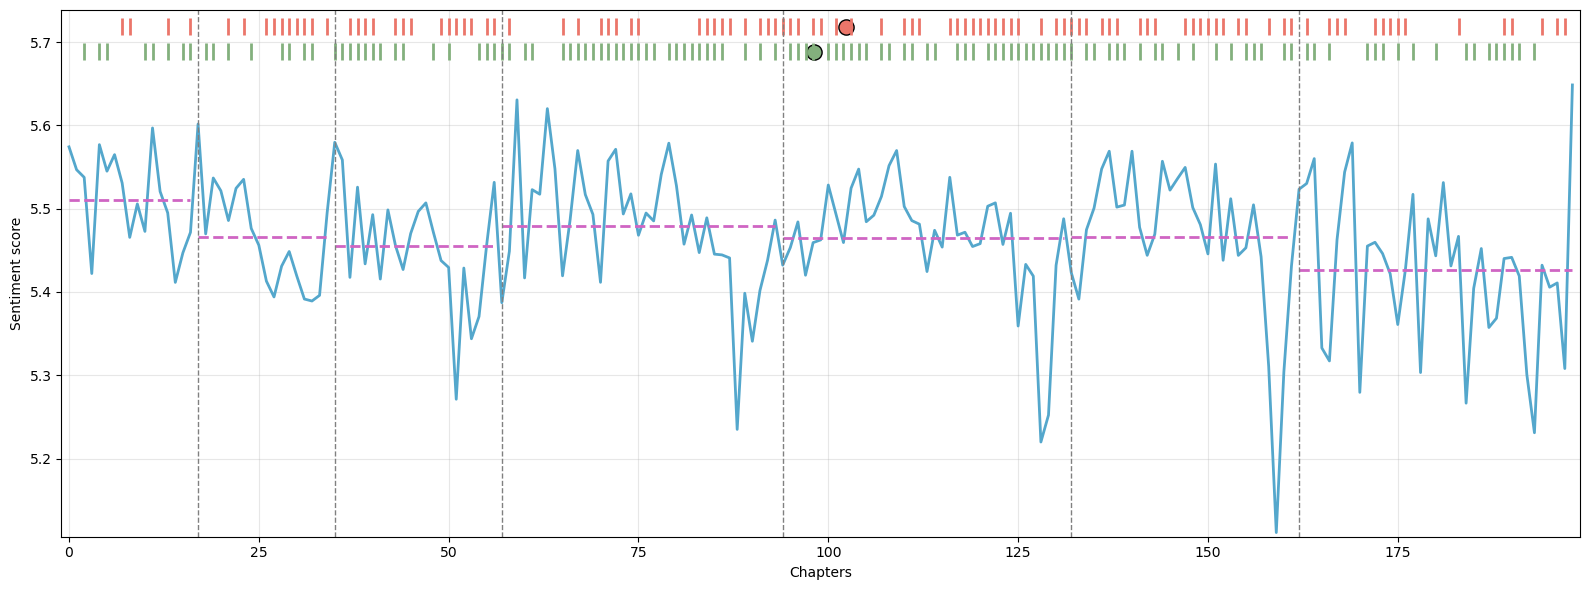

In [60]:
# helper function to extract book number from filename
def extract_book_number(filename):
    digits = "".join(ch for ch in filename if ch.isdigit())
    return int(digits[:2])

# Dispersion plot of the 2 happiest and saddiest locations over chapters, with sentiment trend for all chapters
sorted_books = sorted(books.items(), key=lambda x: extract_book_number(x[0]))

chapters = []
chapter_boundaries = []

for fname, text in sorted_books:
    parts = text.lower().split("--**--")
    book_chapters = ["chapter " + c for c in parts[1:]]
    chapters.extend(book_chapters)
    chapter_boundaries.append(len(chapters))

chapter_indices = list(range(len(chapters)))
sentiments = [sentiment(tokenize(ch)) for ch in chapters]

sorted_loc = sorted(central_places_scores.items(), key=lambda x: x[1])
saddest = [loc.lower() for loc, _ in sorted_loc[:2]]
happiest = [loc.lower() for loc, _ in sorted_loc[-2:]]
print("Happiest locations for ticks:", happiest)
print("Saddest locations for ticks:", saddest)

tick_y_happy = max(sentiments) + 0.03
tick_y_sad = max(sentiments) + 0.06

plt.figure(figsize=(16, 6))
plt.plot(chapter_indices, sentiments, color="#54A7CC", linewidth=2)

happy_positions = []
sad_positions = []

for idx, ch in enumerate(chapters):
    ch_text = " ".join(ch.split())
    if any(loc in ch_text for loc in happiest):
        plt.vlines(idx, tick_y_happy, tick_y_happy + 0.02,
                   color="#83B07D", linewidth=2)
        happy_positions.append(idx)
    if any(loc in ch_text for loc in saddest):
        plt.vlines(idx, tick_y_sad, tick_y_sad + 0.02,
                   color="#EB766A", linewidth=2)
        sad_positions.append(idx)

if happy_positions:
    mean_happy = sum(happy_positions) / len(happy_positions)
    plt.scatter(mean_happy, tick_y_happy + 0.01, s=120,
                color="#83B07D", edgecolors="black")

if sad_positions:
    mean_sad = sum(sad_positions) / len(sad_positions)
    plt.scatter(mean_sad, tick_y_sad + 0.01, s=120,
                color="#EB766A", edgecolors="black")

start = 0
for end in chapter_boundaries:
    book_sentiments = sentiments[start:end]
    mean_sentiment = sum(book_sentiments) / len(book_sentiments)
    plt.hlines(mean_sentiment, start, end - 1,
               colors="#CF65C3", linestyles="dashed", linewidth=2)
    start = end

for x in chapter_boundaries[:-1]:
    plt.axvline(x=x, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Chapters")
plt.ylabel("Sentiment score")
plt.ylim(min(sentiments) - 0.005, tick_y_sad + 0.03)
plt.xlim(-1, len(chapters))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


It is worth noting that the average sentiment score for each book generally decreases, starting at around $5.5$ in Book 1 and ending at $5.4$ in Book 7. The blue line represents the sentiment score for each chapter. Across all books, there are notable drops in sentiment: in Book 4, the death of Cedric Diggory and the return of Voldemort, in Book 5 the death of Sirius Black, and in Book 6 which shows the lowest overall sentiment, the death of Albus Dumbledore and the subsequent fight. These drops become progressively deeper, reflecting the darkening evolution of the story.
The upper part of the figure shows a dispersion plot of the two happiest (Ministry of Magic and the Lake) and two saddest (Azkaban and Hospital Wing) significant locations, summed across mentions. We see some tendency, the happiest locations appear slightly earlier than the saddest locations on average. There is also an alignment between drops and red ticks at the dispersion plot at the end of book 2. In the later part of book 2, the Chamber of Secrets has been opened, and many students are at the Hospital Wing, including Hermione. The frequent mentioning of the Hospital Wing aligns with the many ticks at the dispersion plot and the below-average sentiment scores for those chapters.

## Conclusion
We saw a changing in significance of locations across the seven graphs indicates a clear temporal evolution in the network. 

To examine whether locations reveal insights about the plot or structure of the story, two analyses were conducted. First, the mean chapter index and standardized sentiment score for each K-means cluster showed an interesting pattern, locations mentioned earlier tended to have higher sentiment, while those appearing later tended to have lower sentiment. The second analysis, which compared chapter-level sentiment spikes with ticks marking mentions of the happiest and saddest locations, produced weaker results. Although the happier locations were, on average, mentioned earlier than the saddest ones, there was no clear correlation between positive sentiment peaks and happy location mentions.